## 1. Modelos forecaster por día

### Objetivo

Determinación de los modelos de predicción de la demanda por día para cada uno de los clúster de demanda.

### Descripción General de notebook

    1. Carga de datos bases 
    2. Agrupación de datos
    3. Feature engenier de las variables a incluir en los modelos
    4. Entrenamiento de los modelos
    5. Backtesting de cada uno de los modelos
    6. Evaluación de cada modelo

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline
import seaborn as sns

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingRegressor, RandomForestRegressor


from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_log_error,mean_squared_error, make_scorer

from joblib import dump, load

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [2]:
datos = pd.read_csv("/Users/miguelflores/Desktop/TFM/Data/DataFrame_Final_Cierre_Cluster_FullFecha.csv",parse_dates=['FECHA'])

En el siguiente código se realiza la agrupación de los datos de los movimientos para cada una de las estaciones de BiciMad por Año, Mes y Día.

Asimismo, se incluyen las variables de Temporada, Día de la Semana, es Festivo y es Fin de Semana. Por otro lado se reemplaza la variable temperatura por dos nuevas variables que son la Temperatura Máxima y la Temperatura Mínima y para el resto de variables meteorológicas se realiza un promedio de los datos del día.

In [3]:
bicimad_def = datos.groupby(['CLUSTER_soloDemanda','ANIO','MES','DIA',
                            'TEMPORADA','DIA_SEMANA', 'Es_Festivo', 
                            'Es_FinSemana']).agg(DEMANDA=('DEMANDA','sum'),
                            TEMP_MAX= ('TEMPERATURA','max'),
                            TEMP_MIN = ('TEMPERATURA','min'),
                            HUMEDAD = ('HUMEDAD','mean'),
                            VIENTO = ('VIENTO','mean'),
                            PRESION = ('PRESION', 'mean'),
                            PRECIPITACION_1h = ('PRECIPITACION_1h','sum'),
                            PRECIPITACION_3h = ('PRECIPITACION_3h','sum'))

bicimad_def = bicimad_def.reset_index()

A continuación, se crea una variable Fecha y las variables Mes, Día de la semana, Es Festivo y es Fin de semana se convierten en variables categóricas para después convertirlas en variables dummies.

Por otro lado, para las variables Temperatura Máxima, Temperatura Mínima, Humedad, Viento, Presión, Precipitación 1h y 3h se realiza una transformación para estandarizarlas.

In [4]:
datos = bicimad_def

datos['FECHA'] =pd.to_datetime({'year': datos['ANIO'],
                                'month': datos["MES"]
                                ,'day':  datos['DIA']},
                                format='%d-%m-%Y', 
                                errors='coerce')

datos['MES']   = datos['MES'].astype('category')
datos['DIA_SEMANA'] = datos['DIA_SEMANA'].astype('category')
datos['Es_Festivo'] = datos['Es_Festivo'].astype('category')
datos['Es_FinSemana'] = datos['Es_FinSemana'].astype('category')

datos = pd.get_dummies(datos, columns=['TEMPORADA','MES',
        'DIA_SEMANA','Es_Festivo','Es_FinSemana'], drop_first=True)

df_NumCols = datos[['TEMP_MAX','TEMP_MIN','HUMEDAD','VIENTO',
                    'PRESION','PRECIPITACION_1h','PRECIPITACION_3h']]

scaler = StandardScaler()
datos[['TEMP_MAX','TEMP_MIN','HUMEDAD','VIENTO','PRESION',
'PRECIPITACION_1h','PRECIPITACION_3h']] = scaler.fit_transform(df_NumCols)
    
datos = datos.drop(['DIA','ANIO'], axis=1)

datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CLUSTER_soloDemanda  4005 non-null   int64         
 1   DEMANDA              4005 non-null   int64         
 2   TEMP_MAX             4005 non-null   float64       
 3   TEMP_MIN             4005 non-null   float64       
 4   HUMEDAD              4005 non-null   float64       
 5   VIENTO               4005 non-null   float64       
 6   PRESION              4005 non-null   float64       
 7   PRECIPITACION_1h     4005 non-null   float64       
 8   PRECIPITACION_3h     4005 non-null   float64       
 9   FECHA                4005 non-null   datetime64[ns]
 10  TEMPORADA_OTONO      4005 non-null   uint8         
 11  TEMPORADA_PRIMAVERA  4005 non-null   uint8         
 12  TEMPORADA_VERANO     4005 non-null   uint8         
 13  MES_2                4005 non-nul

Una vez obtenido el conjunto de datos final, se procede a definir las variables exogenas que serán incluidas a los modelos

In [5]:
# Se seleccionan todas las variables exógenas

variables_exogenas = [column for column in datos.columns
            if column.startswith(('TEMPORADA','MES','DIA_SEMANA',
                        'Es_Festivo','Es_FinSemana'))]

variables_exogenas.extend(['TEMP_MAX', 'TEMP_MIN', 'VIENTO', 
            'PRESION', 'HUMEDAD', 'PRECIPITACION_1h','PRECIPITACION_3h'])

print(variables_exogenas)

['TEMPORADA_OTONO', 'TEMPORADA_PRIMAVERA', 'TEMPORADA_VERANO', 'MES_2', 'MES_3', 'MES_4', 'MES_5', 'MES_6', 'MES_7', 'MES_8', 'MES_9', 'MES_10', 'MES_11', 'MES_12', 'DIA_SEMANA_2', 'DIA_SEMANA_3', 'DIA_SEMANA_4', 'DIA_SEMANA_5', 'DIA_SEMANA_6', 'DIA_SEMANA_7', 'Es_Festivo_1', 'Es_FinSemana_1', 'TEMP_MAX', 'TEMP_MIN', 'VIENTO', 'PRESION', 'HUMEDAD', 'PRECIPITACION_1h', 'PRECIPITACION_3h']


## Cluster 0

Para el entrenamiento de cada uno de los modelos se ha realizado lo siguiente:

 - Selección de los datos del clúster
 - Definir la variable Fecha como indice
 - Indicar que la frecuencia de los datos es diaria
 - Separar los datos de entrenamiento (01/03/2027 a 31/12/2019) y los datos de prueba (01/01/2020 a 29/02/2020)
 - Entrenar cada uno de los modelos utilizando la función ForecastAutoreg
 - Crear un backtesting forecaster para cada uno de los modelos
 - Determinar las métricas de los modelos (R2, MSE y RMSE)

In [6]:
datos_estaciones = datos[datos['CLUSTER_soloDemanda']==0]
datos_estaciones = datos_estaciones.drop(['CLUSTER_soloDemanda'], axis=1)
datos_estaciones = datos_estaciones.drop_duplicates(subset ='FECHA',keep='last')
datos_estaciones = datos_estaciones.set_index('FECHA')
datos_estaciones = datos_estaciones.asfreq('D')
datos_estaciones = datos_estaciones.sort_index()

datos_estaciones = datos_estaciones.loc[datos_estaciones.index.min(): datos_estaciones.index.max()]
fin_train = '2019-12-31'
fin_test = '2020-02-29'

datos_train = datos_estaciones.loc[: fin_train, :]
datos_test   = datos_estaciones.loc[fin_train:fin_test, :]


y_true = datos_estaciones.loc[fin_train:, 'DEMANDA']
y_true = pd.DataFrame(y_true.iloc[1: ,])
y_true

forecaster_LGBM = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_LGBM, predicciones_LGBM = backtesting_forecaster(
                forecaster = forecaster_LGBM,
                y = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                exog = datos_estaciones.loc[:fin_test, variables_exogenas],    
                initial_train_size = int(len(datos_train)),
                fixed_train_size = False,
                steps = 24,
                metric = 'mean_absolute_error',
                refit = False,
                verbose = True)

score_LGBM = r2_score(y_true, predicciones_LGBM)
mse_LGBM = mean_squared_error(y_true, predicciones_LGBM)
rmse_LGBM = mse_LGBM**(0.5)


forecaster_XGB = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_XGB, predicciones_XGB = backtesting_forecaster(
               forecaster = forecaster_XGB,
               y = datos_estaciones.loc[:fin_test, 'DEMANDA'],
               exog = datos_estaciones.loc[:fin_test, variables_exogenas],    
               initial_train_size = int(len(datos_train)),
               fixed_train_size = False,
               steps = 24,
               metric = 'mean_absolute_error',
               refit = False,
               verbose = True)

score_XGB = r2_score(y_true, predicciones_XGB)
mse_XGB = mean_squared_error(y_true, predicciones_XGB)
rmse_XGB = mse_XGB**(0.5)


forecaster_RF = ForecasterAutoreg(
            regressor = RandomForestRegressor(random_state=123),
            lags      = [1,2,3])

metrica_RF, predicciones_RF = backtesting_forecaster(
              forecaster = forecaster_RF,
              y = datos_estaciones.loc[:fin_test, 'DEMANDA'],
              exog = datos_estaciones.loc[:fin_test, variables_exogenas],    
              initial_train_size = int(len(datos_train)),
              fixed_train_size = False,
              steps = 24,
              metric = 'mean_absolute_error',
              refit = False,
              verbose = True)

score_RF = r2_score(y_true, predicciones_RF)
mse_RF = mean_squared_error(y_true, predicciones_RF)
rmse_RF = mse_RF**(0.5)


forecaster_GB = ForecasterAutoreg(
    regressor = GradientBoostingRegressor(random_state=123),
    lags      = [1,2,3])

metrica_GB, predicciones_GB = backtesting_forecaster(
              forecaster = forecaster_GB,
              y = datos_estaciones.loc[:fin_test, 'DEMANDA'],
              exog = datos_estaciones.loc[:fin_test, variables_exogenas],    
              initial_train_size = int(len(datos_train)),
              fixed_train_size = False,
              steps = 24,
              metric = 'mean_absolute_error',
              refit = False,
              verbose = True)

score_GB = r2_score(y_true, predicciones_GB)
mse_GB = mean_squared_error(y_true, predicciones_GB)
rmse_GB = mse_GB**(0.5)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 730
Number of observations used for backtesting: 60
    Number of folds: 3
    Number of steps per fold: 24
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 00:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-24 00:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 00:00:00
    Validation: 2020-01-25 00:00:00 -- 2020-02-17 00:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 00:00:00
    Validation: 2020-02-18 00:00:00 -- 2020-02-29 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 730
Number of observations used for backtesting: 60
    Number of folds: 3
    Number of steps per fold: 24
    Last fold only inclu

In [7]:
print('---------Evaluación del modelo RF---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_RF))
print("Mean Absolute Error: %.2f" % mse_RF)
print("Root Mean Squared Error: %.2f" % rmse_RF)
print('')

print('---------Evaluación del modelo LGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_LGBM))
print("Mean Absolute Error: %.2f" % mse_LGBM)
print("Root Mean Squared Error: %.2f" % rmse_LGBM)
print('')

print('---------Evaluación del modelo GB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_GB))
print("Mean Absolute Error: %.2f" % mse_GB)
print("Root Mean Squared Error: %.2f" % rmse_GB)
print('')

print('---------Evaluación del modelo XGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_XGB))
print("Mean Absolute Error: %.2f" % mse_XGB)
print("Root Mean Squared Error: %.2f" % rmse_XGB)
print('')

---------Evaluación del modelo RF---------------
R^2 Coefficient of Determination: 0.74.
Mean Absolute Error: 69603.05
Root Mean Squared Error: 263.82

---------Evaluación del modelo LGB---------------
R^2 Coefficient of Determination: 0.68.
Mean Absolute Error: 85344.61
Root Mean Squared Error: 292.14

---------Evaluación del modelo GB---------------
R^2 Coefficient of Determination: 0.40.
Mean Absolute Error: 162538.60
Root Mean Squared Error: 403.16

---------Evaluación del modelo XGB---------------
R^2 Coefficient of Determination: 0.65.
Mean Absolute Error: 94982.05
Root Mean Squared Error: 308.19



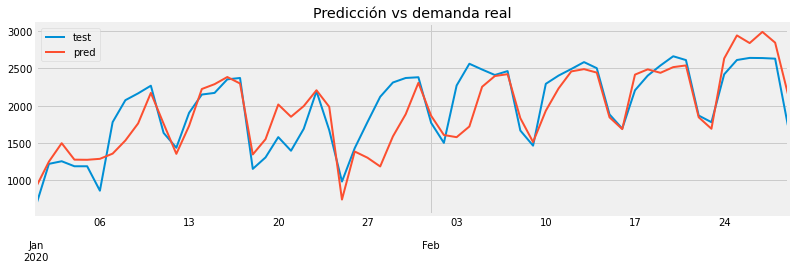

In [8]:
fig, ax = plt.subplots(figsize=(12, 3.5))
datos_estaciones.loc[predicciones_RF.index, 'DEMANDA'].plot(linewidth=2, label='test', ax=ax)
predicciones_XGB.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

## Cluster 1

In [9]:
datos_estaciones = datos[datos['CLUSTER_soloDemanda']==1]
datos_estaciones = datos_estaciones.drop(['CLUSTER_soloDemanda'], axis=1)
datos_estaciones = datos_estaciones.drop_duplicates(subset = 'FECHA',keep='last')
datos_estaciones = datos_estaciones.set_index('FECHA')
datos_estaciones = datos_estaciones.asfreq('D')
datos_estaciones = datos_estaciones.sort_index()

datos_estaciones = datos_estaciones.loc[datos_estaciones.index.min(): datos_estaciones.index.max()]
fin_train = '2019-12-31 23:59:00'
fin_test = '2020-02-29 23:00:00'

datos_train = datos_estaciones.loc[: fin_train, :]
datos_test   = datos_estaciones.loc[fin_train:fin_test, :]

y_true = datos_estaciones.loc[fin_train:, 'DEMANDA']

forecaster_LGBM = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_LGBM, predicciones_LGBM = backtesting_forecaster(
                            forecaster = forecaster_LGBM,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_LGBM = r2_score(y_true, predicciones_LGBM)
mse_LGBM = mean_squared_error(y_true, predicciones_LGBM)
rmse_LGBM = mse_LGBM**(0.5)


forecaster_XGB = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_XGB, predicciones_XGB = backtesting_forecaster(
                            forecaster = forecaster_XGB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )


score_XGB = r2_score(y_true, predicciones_XGB)
mse_XGB = mean_squared_error(y_true, predicciones_XGB)
rmse_XGB = mse_XGB**(0.5)


forecaster_RF = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_RF, predicciones_RF = backtesting_forecaster(
                            forecaster = forecaster_RF,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_RF = r2_score(y_true, predicciones_RF)
mse_RF = mean_squared_error(y_true, predicciones_RF)
rmse_RF = mse_RF**(0.5)


forecaster_GB = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_GB, predicciones_GB = backtesting_forecaster(
                            forecaster = forecaster_GB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_GB = r2_score(y_true, predicciones_GB)
mse_GB = mean_squared_error(y_true, predicciones_GB)
rmse_GB = mse_GB**(0.5)


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 730
Number of observations used for backtesting: 60
    Number of folds: 3
    Number of steps per fold: 24
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 00:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-24 00:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 00:00:00
    Validation: 2020-01-25 00:00:00 -- 2020-02-17 00:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 00:00:00
    Validation: 2020-02-18 00:00:00 -- 2020-02-29 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 730
Number of observations used for backtesting: 60
    Number of folds: 3
    Number of steps per fold: 24
    Last fold only inclu

In [10]:
print('---------Evaluación del modelo RF---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_RF ))
print("Mean Absolute Error: %.2f" % mse_RF)
print("Root Mean Squared Error: %.2f" % rmse_RF)
print('')

print('---------Evaluación del modelo LGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_LGBM))
print("Mean Absolute Error: %.2f" % mse_LGBM)
print("Root Mean Squared Error: %.2f" % rmse_LGBM)
print('')

print('---------Evaluación del modelo GB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_GB))
print("Mean Absolute Error: %.2f" % mse_GB)
print("Root Mean Squared Error: %.2f" % rmse_GB)
print('')

print('---------Evaluación del modelo XGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_XGB))
print("Mean Absolute Error: %.2f" % mse_XGB)
print("Root Mean Squared Error: %.2f" % rmse_XGB)
print('')

---------Evaluación del modelo RF---------------
R^2 Coefficient of Determination: 0.75.
Mean Absolute Error: 47066.26
Root Mean Squared Error: 216.95

---------Evaluación del modelo LGB---------------
R^2 Coefficient of Determination: 0.80.
Mean Absolute Error: 38588.82
Root Mean Squared Error: 196.44

---------Evaluación del modelo GB---------------
R^2 Coefficient of Determination: 0.72.
Mean Absolute Error: 52849.93
Root Mean Squared Error: 229.89

---------Evaluación del modelo XGB---------------
R^2 Coefficient of Determination: 0.78.
Mean Absolute Error: 42217.78
Root Mean Squared Error: 205.47



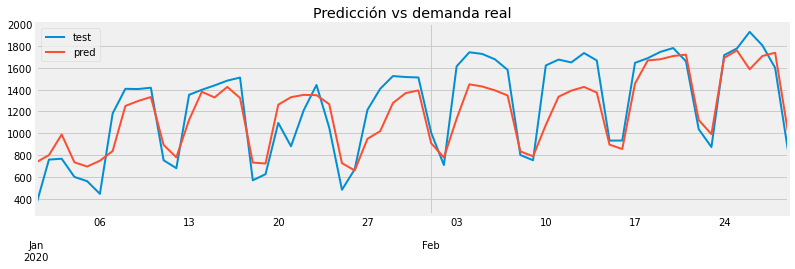

In [11]:
fig, ax = plt.subplots(figsize=(12, 3.5))
datos_estaciones.loc[predicciones_LGBM.index, 'DEMANDA'].plot(linewidth=2, label='test', ax=ax)
predicciones_RF.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

## Cluster 2

In [12]:
datos_estaciones = datos[datos['CLUSTER_soloDemanda']==2]
datos_estaciones = datos_estaciones.drop(['CLUSTER_soloDemanda'], axis=1)
datos_estaciones = datos_estaciones.drop_duplicates(subset = 'FECHA',keep='last')
datos_estaciones = datos_estaciones.set_index('FECHA')
datos_estaciones = datos_estaciones.asfreq('D')
datos_estaciones = datos_estaciones.sort_index()

datos_estaciones = datos_estaciones.loc[datos_estaciones.index.min(): datos_estaciones.index.max()]
fin_train = '2019-12-31 23:59:00'
fin_test = '2020-02-29 23:00:00'

datos_train = datos_estaciones.loc[: fin_train, :]
datos_test   = datos_estaciones.loc[fin_train:fin_test, :]

y_true = datos_estaciones.loc[fin_train:, 'DEMANDA']

forecaster_LGBM = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_LGBM, predicciones_LGBM = backtesting_forecaster(
                            forecaster = forecaster_LGBM,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )


score_LGBM = r2_score(y_true, predicciones_LGBM)
mse_LGBM = mean_squared_error(y_true, predicciones_LGBM)
rmse_LGBM = mse_LGBM**(0.5)


forecaster_XGB = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_XGB, predicciones_XGB = backtesting_forecaster(
                            forecaster = forecaster_XGB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )


score_XGB = r2_score(y_true, predicciones_XGB)
mse_XGB = mean_squared_error(y_true, predicciones_XGB)
rmse_XGB = mse_XGB**(0.5)


forecaster_RF = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_RF, predicciones_RF = backtesting_forecaster(
                            forecaster = forecaster_RF,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_RF = r2_score(y_true, predicciones_RF)
mse_RF = mean_squared_error(y_true, predicciones_RF)
rmse_RF = mse_RF**(0.5)


forecaster_GB = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_GB, predicciones_GB = backtesting_forecaster(
                            forecaster = forecaster_GB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_GB = r2_score(y_true, predicciones_GB)
mse_GB = mean_squared_error(y_true, predicciones_GB)
rmse_GB = mse_GB**(0.5)


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 730
Number of observations used for backtesting: 60
    Number of folds: 3
    Number of steps per fold: 24
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 00:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-24 00:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 00:00:00
    Validation: 2020-01-25 00:00:00 -- 2020-02-17 00:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 00:00:00
    Validation: 2020-02-18 00:00:00 -- 2020-02-29 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 730
Number of observations used for backtesting: 60
    Number of folds: 3
    Number of steps per fold: 24
    Last fold only inclu

In [13]:
print('---------Evaluación del modelo RF---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_RF ))
print("Mean Absolute Error: %.2f" % mse_RF)
print("Root Mean Squared Error: %.2f" % rmse_RF)
print('')

print('---------Evaluación del modelo LGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_LGBM))
print("Mean Absolute Error: %.2f" % mse_LGBM)
print("Root Mean Squared Error: %.2f" % rmse_LGBM)
print('')

print('---------Evaluación del modelo GB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_GB))
print("Mean Absolute Error: %.2f" % mse_GB)
print("Root Mean Squared Error: %.2f" % rmse_GB)
print('')

print('---------Evaluación del modelo XGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_XGB))
print("Mean Absolute Error: %.2f" % mse_XGB)
print("Root Mean Squared Error: %.2f" % rmse_XGB)
print('')

---------Evaluación del modelo RF---------------
R^2 Coefficient of Determination: 0.69.
Mean Absolute Error: 28162.42
Root Mean Squared Error: 167.82

---------Evaluación del modelo LGB---------------
R^2 Coefficient of Determination: 0.61.
Mean Absolute Error: 34886.14
Root Mean Squared Error: 186.78

---------Evaluación del modelo GB---------------
R^2 Coefficient of Determination: 0.64.
Mean Absolute Error: 32573.81
Root Mean Squared Error: 180.48

---------Evaluación del modelo XGB---------------
R^2 Coefficient of Determination: 0.69.
Mean Absolute Error: 28252.92
Root Mean Squared Error: 168.09



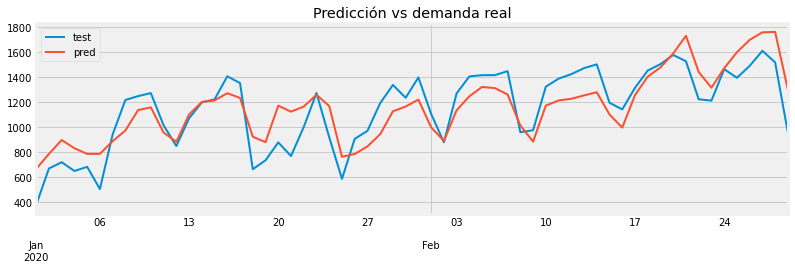

In [14]:
fig, ax = plt.subplots(figsize=(12, 3.5))
datos_estaciones.loc[predicciones_RF.index, 'DEMANDA'].plot(linewidth=2, label='test', ax=ax)
predicciones_RF.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

## Cluster 3

In [15]:
datos_estaciones = datos[datos['CLUSTER_soloDemanda']==3]
datos_estaciones = datos_estaciones.drop(['CLUSTER_soloDemanda'], axis=1)

datos_estaciones = datos_estaciones.drop_duplicates(subset = 'FECHA',keep='last')
datos_estaciones = datos_estaciones.set_index('FECHA')
datos_estaciones = datos_estaciones.asfreq('D')
datos_estaciones = datos_estaciones.sort_index()

datos_estaciones = datos_estaciones.loc[datos_estaciones.index.min(): datos_estaciones.index.max()]
fin_train = '2019-12-31 23:59:00'
fin_test = '2020-02-29 23:00:00'

datos_train = datos_estaciones.loc[: fin_train, :]
datos_test   = datos_estaciones.loc[fin_train:fin_test, :]

y_true = datos_estaciones.loc[fin_train:, 'DEMANDA']

forecaster_LGBM = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_LGBM, predicciones_LGBM = backtesting_forecaster(
                            forecaster = forecaster_LGBM,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )


score_LGBM = r2_score(y_true, predicciones_LGBM)
mse_LGBM = mean_squared_error(y_true, predicciones_LGBM)
rmse_LGBM = mse_LGBM**(0.5)


forecaster_XGB = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_XGB, predicciones_XGB = backtesting_forecaster(
                            forecaster = forecaster_XGB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )


score_XGB = r2_score(y_true, predicciones_XGB)
mse_XGB = mean_squared_error(y_true, predicciones_XGB)
rmse_XGB = mse_XGB**(0.5)


forecaster_RF = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_RF, predicciones_RF = backtesting_forecaster(
                            forecaster = forecaster_RF,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_RF = r2_score(y_true, predicciones_RF)
mse_RF = mean_squared_error(y_true, predicciones_RF)
rmse_RF = mse_RF**(0.5)


forecaster_GB = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_GB, predicciones_GB = backtesting_forecaster(
                            forecaster = forecaster_GB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_GB = r2_score(y_true, predicciones_GB)
mse_GB = mean_squared_error(y_true, predicciones_GB)
rmse_GB = mse_GB**(0.5)


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 730
Number of observations used for backtesting: 60
    Number of folds: 3
    Number of steps per fold: 24
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 00:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-24 00:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 00:00:00
    Validation: 2020-01-25 00:00:00 -- 2020-02-17 00:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 00:00:00
    Validation: 2020-02-18 00:00:00 -- 2020-02-29 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 730
Number of observations used for backtesting: 60
    Number of folds: 3
    Number of steps per fold: 24
    Last fold only inclu

In [16]:
print('---------Evaluación del modelo RF---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_RF ))
print("Mean Absolute Error: %.2f" % mse_RF)
print("Root Mean Squared Error: %.2f" % rmse_RF)
print('')

print('---------Evaluación del modelo LGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_LGBM))
print("Mean Absolute Error: %.2f" % mse_LGBM)
print("Root Mean Squared Error: %.2f" % rmse_LGBM)
print('')

print('---------Evaluación del modelo GB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_GB))
print("Mean Absolute Error: %.2f" % mse_GB)
print("Root Mean Squared Error: %.2f" % rmse_GB)
print('')

print('---------Evaluación del modelo XGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_XGB))
print("Mean Absolute Error: %.2f" % mse_XGB)
print("Root Mean Squared Error: %.2f" % rmse_XGB)
print('')

---------Evaluación del modelo RF---------------
R^2 Coefficient of Determination: 0.80.
Mean Absolute Error: 78420.05
Root Mean Squared Error: 280.04

---------Evaluación del modelo LGB---------------
R^2 Coefficient of Determination: 0.40.
Mean Absolute Error: 229435.22
Root Mean Squared Error: 478.99

---------Evaluación del modelo GB---------------
R^2 Coefficient of Determination: 0.61.
Mean Absolute Error: 142564.15
Root Mean Squared Error: 377.58

---------Evaluación del modelo XGB---------------
R^2 Coefficient of Determination: 0.61.
Mean Absolute Error: 148965.36
Root Mean Squared Error: 385.96



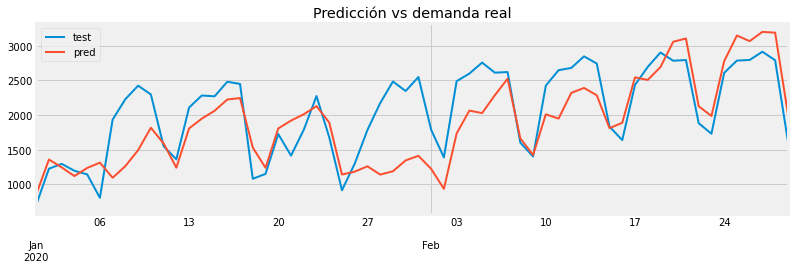

In [17]:
fig, ax = plt.subplots(figsize=(12, 3.5))
datos_estaciones.loc[predicciones_RF.index, 'DEMANDA'].plot(linewidth=2, label='test', ax=ax)
predicciones_LGBM.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

## Cluster 4

In [18]:
datos_estaciones = datos[datos['CLUSTER_soloDemanda']==4]
datos_estaciones = datos_estaciones.drop(['CLUSTER_soloDemanda'], axis=1)

datos_estaciones = datos_estaciones.drop_duplicates(subset = 'FECHA',keep='last')
datos_estaciones = datos_estaciones.set_index('FECHA')
datos_estaciones = datos_estaciones.asfreq('D')
datos_estaciones = datos_estaciones.sort_index()

datos_estaciones = datos_estaciones.loc[datos_estaciones.index.min(): datos_estaciones.index.max()]
fin_train = '2019-12-31 23:59:00'
fin_test = '2020-02-29 23:00:00'

datos_train = datos_estaciones.loc[: fin_train, :]
datos_test   = datos_estaciones.loc[fin_train:fin_test, :]

y_true = datos_estaciones.loc[fin_train:, 'DEMANDA']

forecaster_LGBM = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_LGBM, predicciones_LGBM = backtesting_forecaster(
                            forecaster = forecaster_LGBM,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )


score_LGBM = r2_score(y_true, predicciones_LGBM)
mse_LGBM = mean_squared_error(y_true, predicciones_LGBM)
rmse_LGBM = mse_LGBM**(0.5)


forecaster_XGB = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_XGB, predicciones_XGB = backtesting_forecaster(
                            forecaster = forecaster_XGB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )


score_XGB = r2_score(y_true, predicciones_XGB)
mse_XGB = mean_squared_error(y_true, predicciones_XGB)
rmse_XGB = mse_XGB**(0.5)


forecaster_RF = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_RF, predicciones_RF = backtesting_forecaster(
                            forecaster = forecaster_RF,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_RF = r2_score(y_true, predicciones_RF)
mse_RF = mean_squared_error(y_true, predicciones_RF)
rmse_RF = mse_RF**(0.5)


forecaster_GB = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(random_state=123),
                lags      = [1,2,3]
             )

metrica_GB, predicciones_GB = backtesting_forecaster(
                            forecaster = forecaster_GB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_GB = r2_score(y_true, predicciones_GB)
mse_GB = mean_squared_error(y_true, predicciones_GB)
rmse_GB = mse_GB**(0.5)


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 730
Number of observations used for backtesting: 60
    Number of folds: 3
    Number of steps per fold: 24
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 00:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-24 00:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 00:00:00
    Validation: 2020-01-25 00:00:00 -- 2020-02-17 00:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 00:00:00
    Validation: 2020-02-18 00:00:00 -- 2020-02-29 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 730
Number of observations used for backtesting: 60
    Number of folds: 3
    Number of steps per fold: 24
    Last fold only inclu

In [19]:
print('---------Evaluación del modelo RF---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_RF ))
print("Mean Absolute Error: %.2f" % mse_RF)
print("Root Mean Squared Error: %.2f" % rmse_RF)
print('')

print('---------Evaluación del modelo LGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_LGBM))
print("Mean Absolute Error: %.2f" % mse_LGBM)
print("Root Mean Squared Error: %.2f" % rmse_LGBM)
print('')

print('---------Evaluación del modelo GB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_GB))
print("Mean Absolute Error: %.2f" % mse_GB)
print("Root Mean Squared Error: %.2f" % rmse_GB)
print('')

print('---------Evaluación del modelo XGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_XGB))
print("Mean Absolute Error: %.2f" % mse_XGB)
print("Root Mean Squared Error: %.2f" % rmse_XGB)
print('')

---------Evaluación del modelo RF---------------
R^2 Coefficient of Determination: 0.77.
Mean Absolute Error: 47813.44
Root Mean Squared Error: 218.66

---------Evaluación del modelo LGB---------------
R^2 Coefficient of Determination: 0.44.
Mean Absolute Error: 117177.73
Root Mean Squared Error: 342.31

---------Evaluación del modelo GB---------------
R^2 Coefficient of Determination: 0.67.
Mean Absolute Error: 70274.41
Root Mean Squared Error: 265.09

---------Evaluación del modelo XGB---------------
R^2 Coefficient of Determination: 0.62.
Mean Absolute Error: 79193.36
Root Mean Squared Error: 281.41



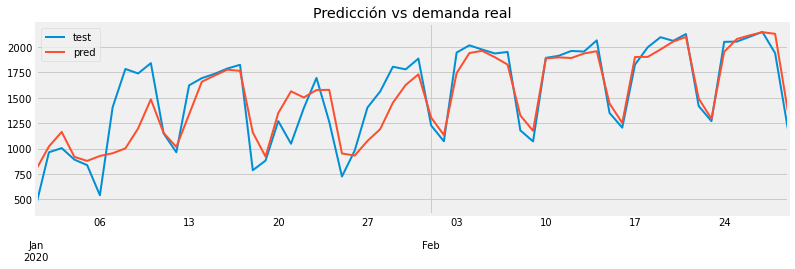

In [20]:
fig, ax = plt.subplots(figsize=(12, 3.5))
datos_estaciones.loc[predicciones_RF.index, 'DEMANDA'].plot(linewidth=2, label='test', ax=ax)
predicciones_RF.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();